In [2]:
import numpy as np
from fit_types import *
from tc_utils import *
material = "SS304"

In [3]:
TCdata = np.loadtxt("..\\thermal_conductivity_compilation.csv", dtype=str, delimiter=',')
headers = TCdata[0]


mat_names = TCdata[:,0]
mat_row = TCdata[int(np.argwhere(mat_names == material))]

In [4]:
print(mat_row)
num_hi = sum(1 for c in headers[4:] if c.isupper())
num_low = sum(1 for c in headers[4:-1] if c.islower())
fit_params = mat_row
fit_params = np.char.replace(fit_params, "^", "0")

['SS304' 'loglog' '0.385' '1672.000' '3.953' '2.23367e-07' '-5.04296e-05'
 '3.01386e-03' '6.96502e-02' '^' '^' '^' '^' '^' '1.19786e+02'
 '3.42081e-02' '-1.71132e-01' '6.23536e-01' '1.49213e-01']


In [5]:
parameter_dict = dict(zip(headers, fit_params))
print(parameter_dict)

{'Material Name': 'SS304', 'Fit Type': 'loglog', 'Low Temp': '0.385', 'High Temp': '1672.000', 'Perc Err': '3.953', 'a': '2.23367e-07', 'b': '-5.04296e-05', 'c': '3.01386e-03', 'd': '6.96502e-02', 'e': '0', 'f': '0', 'g': '0', 'h': '0', 'i': '0', 'erf param': '1.19786e+02', 'A': '3.42081e-02', 'B': '-1.71132e-01', 'C': '6.23536e-01', 'D': '1.49213e-01'}


In [6]:
def zero_filter(arr):
    filtered_arr = []
    for i in range(len(arr)):
        if arr[i] == 0:
            if i == 0 and arr[i + 1] != 0:
                filtered_arr.append(arr[i])
            elif arr[i - 1] != 0 and arr[i + 1] != 0:
                print(i)
                filtered_arr.append(arr[i])
        else:
            filtered_arr.append(arr[i])

    filtered_arr = np.array(filtered_arr)
    return filtered_arr

In [7]:
T = np.linspace(float(parameter_dict["Low Temp"]), float(parameter_dict["High Temp"]), 10000)
T = np.logspace(np.log10(float(parameter_dict["Low Temp"])),np.log10(float(parameter_dict["High Temp"])),100)

low_param = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_low -1, "l")]
hi_param = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_hi, "H")]
erf_param = float(parameter_dict["erf param"])

print(low_param)
low_param = zero_filter(low_param)
hi_param = zero_filter(hi_param)

print(low_param, hi_param, erf_param)

k = loglog_func(T, low_param, hi_param, erf_param)

[2.23367e-07, -5.04296e-05, 0.00301386, 0.0696502, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 2.23367e-07 -5.04296e-05  3.01386e-03  6.96502e-02] [ 0.0342081 -0.171132   0.623536   0.149213 ] 119.786


In [8]:
def definite_integral(x, y, start_x, end_x):
    """
    Compute the definite integral of a function given x and y values between specified bounds using the trapezoidal rule.

    Parameters:
    x (list or array): The x values.
    y (list or array): The corresponding y values.
    start_x (float): The starting x value for integration.
    end_x (float): The ending x value for integration.

    Returns:
    float: The definite integral of the function between the specified bounds.
    """
    # Find indices corresponding to the closest x values to start_x and end_x
    start_index = min(range(len(x)), key=lambda i: abs(x[i] - start_x))
    end_index = min(range(len(x)), key=lambda i: abs(x[i] - end_x))

    # Ensure start_index is not greater than end_index
    start_index, end_index = min(start_index, end_index), max(start_index, end_index)

    integral = 0.0
    for i in range(start_index + 1, end_index + 1):
        integral += (x[i] - x[i-1]) * (y[i] + y[i-1]) / 2.0
    return integral

# Example usage:
x_values = T  # Example x values
y_values = k  # Example y values (squared values of x)
start_x = 189.2  # Start x value for integration
end_x = 260  # End x value for integration
result = definite_integral(x_values, y_values, start_x, end_x)
print("Definite integral between", start_x, "and", end_x, ":", result)



Definite integral between 189.2 and 260 : 965.9229353342132


NIST Fit and Integral

In [9]:
TCdata = np.loadtxt("..\\thermal_conductivity_compilation_NIST.csv", dtype=str, delimiter=',')
headers = TCdata[0]


mat_names = TCdata[:,0]
mat_row = TCdata[int(np.argwhere(mat_names == material))]

In [10]:
print(mat_row)
num_hi = sum(1 for c in headers[4:] if c.isupper())
num_low = sum(1 for c in headers[4:-1] if c.islower())
fit_params = mat_row
fit_params = np.char.replace(fit_params, "^", "0")

['SS304' 'NIST-1' '4.000' '300.000' '2.0' '-1.40870e+00' '1.39820e+00'
 '2.54300e-01' '-6.26000e-01' '2.33400e-01' '4.25600e-01' '-4.65800e-01'
 '1.65000e-01' '-1.99000e-02']


In [11]:
parameter_dict = dict(zip(headers, fit_params))
print(parameter_dict)

{'Material Name': 'SS304', 'Fit Type': 'NIST-1', 'Low Temp': '4.000', 'High Temp': '300.000', 'Perc Err': '2.0', 'a': '-1.40870e+00', 'b': '1.39820e+00', 'c': '2.54300e-01', 'd': '-6.26000e-01', 'e': '2.33400e-01', 'f': '4.25600e-01', 'g': '-4.65800e-01', 'h': '1.65000e-01', 'i': '-1.99000e-02'}


In [12]:
params_NIST = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_low+1, "l")]
params_NIST = np.flip(params_NIST)
print(np.poly1d(params_NIST))
k_Nist = NIST1(T, params_NIST)


         8         7          6          5          4         3
-0.0199 x + 0.165 x - 0.4658 x + 0.4256 x + 0.2334 x - 0.626 x
           2
 + 0.2543 x + 1.398 x - 1.409


In [13]:
# Example usage:
x_values = T  # Example x values
y_values = k  # Example y values (squared values of x)
start_x = 189.2  # Start x value for integration
end_x = 260  # End x value for integration
result = definite_integral(x_values, y_values, start_x, end_x)
print("Definite integral between", start_x, "and", end_x, ":", result)

Definite integral between 189.2 and 260 : 965.9229353342132


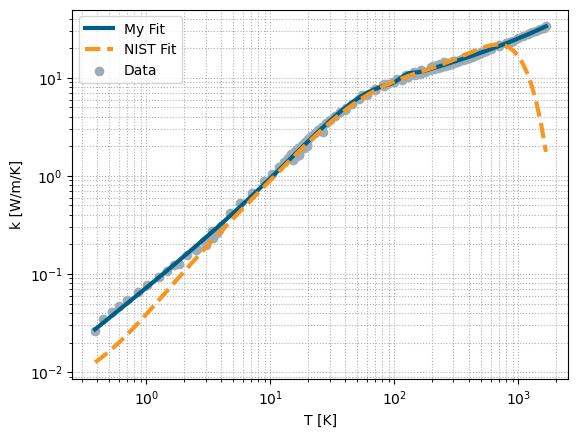

In [52]:
big_data, data_dict = parse_raw(material, f"lib\{material}\RAW", plots=False)
T_data = big_data[:,0]
k_data = big_data[:,1]

from matplotlib.colors import LinearSegmentedColormap

# colors = [(0, '#333f48'), (0.5, '#d6d2c4'), (1, '#9cadb7'), (0, '#005f86'), (0.5, '#00a9b7'), (1, '#579d42'), (0, '#a6cd57'), (0.5, '#ffd600'), (1, '#f8971f')]
colors = ['#333f48', '#d6d2c4', '#9cadb7', '#005f86', '#00a9b7', '#579d42', '#a6cd57', '#ffd600', '#f8971f']

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


plt.plot(T, k, color=colors[3], linestyle="-", linewidth = 3, label="My Fit")
plt.plot(T, k_Nist, color=colors[-1], linestyle="--", linewidth = 3, label="NIST Fit")
# plt.plot(T_data, k_data, '.', color=colors[2], markersize=9, alpha=0.3, label="data")
plt.scatter(T_data, k_data, c=colors[2], label = "Data")
plt.ylabel("k [W/m/K]")
plt.xlabel("T [K]")
plt.legend()
plt.semilogy()
plt.semilogx()
plt.grid(True, which="both", linestyle=':')

plt.show()


In [56]:
def power_load(area, length, conInt):
    return area/length*conInt

od = 35.625*0.0254 # m
l = 29*0.0254 # m
mat_thickness = 0.0625*0.0254

area = np.pi*((od/2)**2-((od/2)-mat_thickness)**2)

print(area, area/l, result)
power_load(area, l, result)


0.004504946181351276 0.006115865030343845 965.9229353342132


5.907454302217594